Connected to base (Python 3.11.7)

Computing base model...

PART 1: BASIC MODEL VISUALIZATION


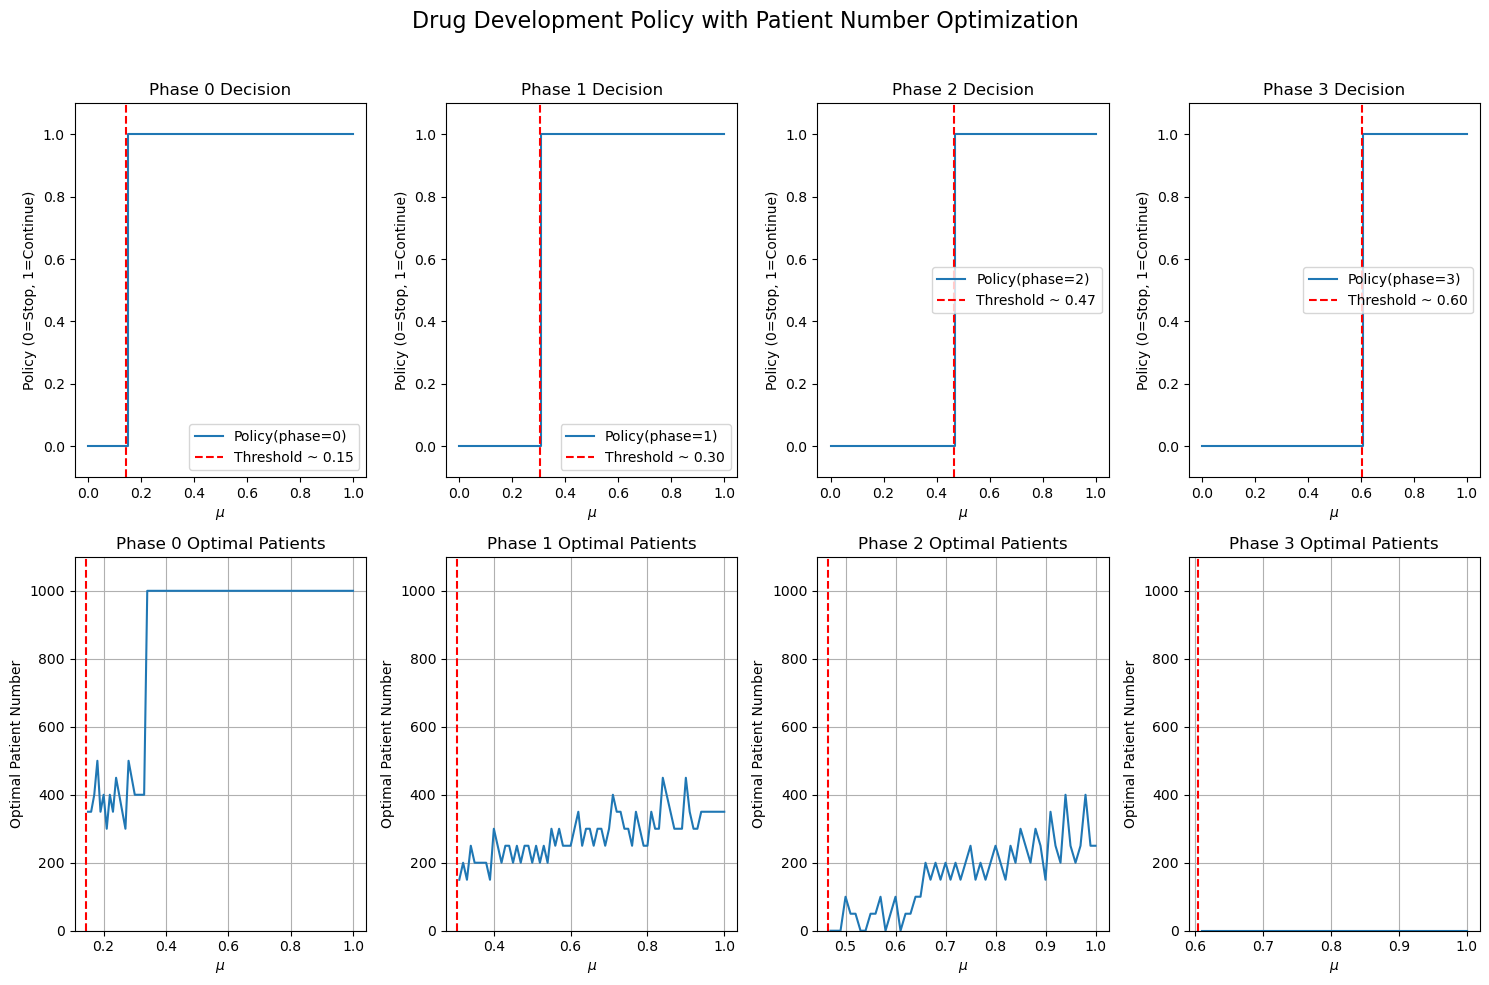


Optimal Belief Thresholds:
  Phase 0: μ* = 0.1450
  Phase 1: μ* = 0.3050
  Phase 2: μ* = 0.4650
  Phase 3: μ* = 0.6050

Simulating drug development paths starting with belief μ = 0.6...
Overall success rate: 11.50%
Average patients enrolled: 1374.0
Average development cost: $136.5M

Phase progression rates:
  Reached Phase 1: 62.40%
  Reached Phase 2: 46.70%
  Reached Phase 3: 26.50%
  Reached Phase 4: 11.50%


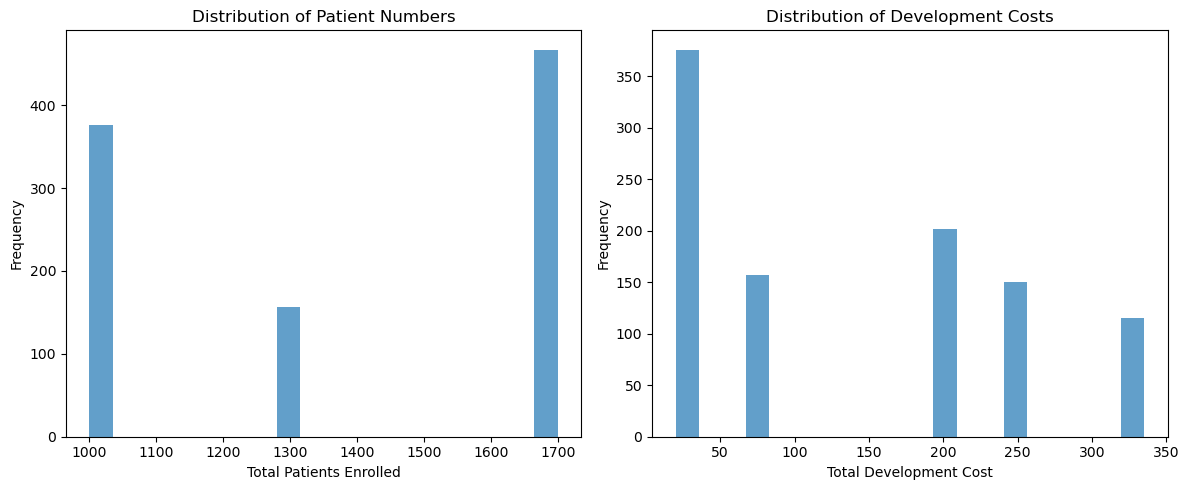


PART 2: PARAMETER SENSITIVITY ANALYSIS

Analyzing threshold sensitivity to market payoff (P)...


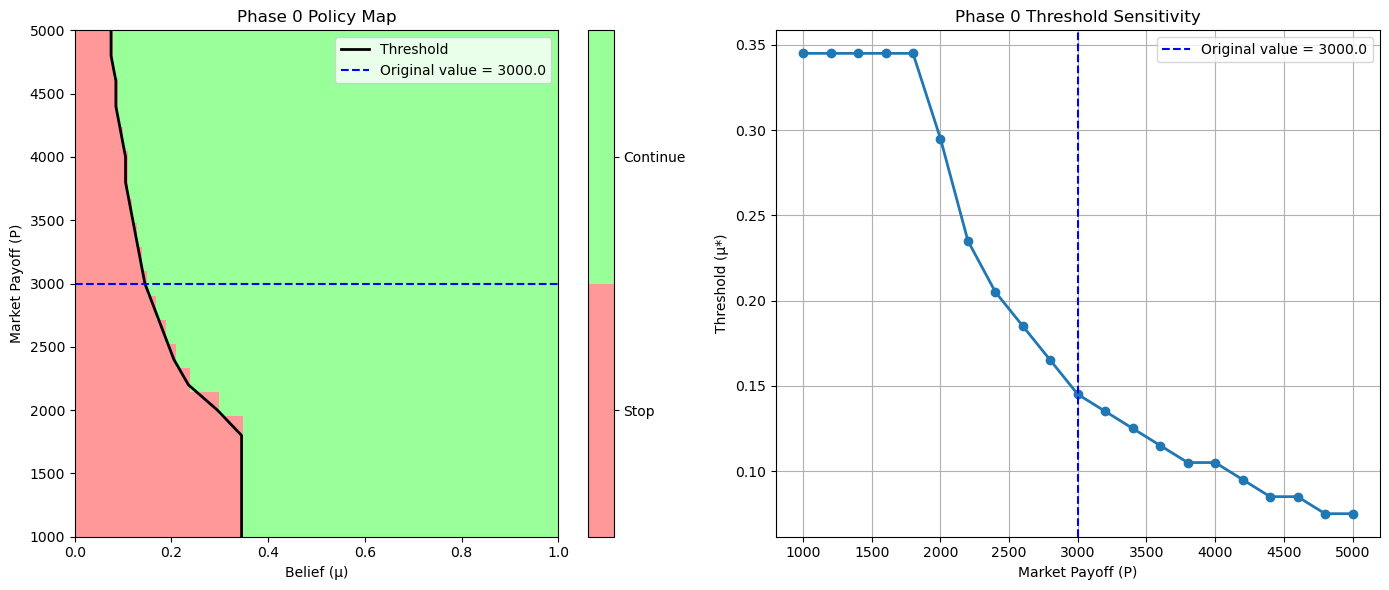

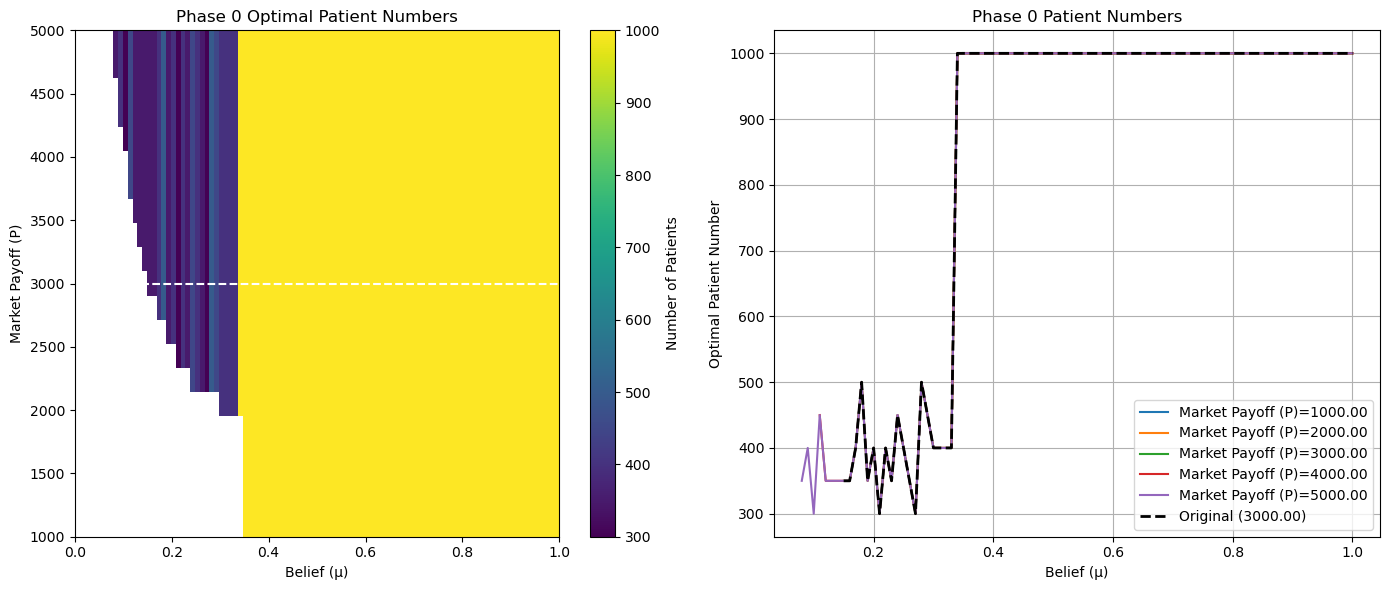


Analyzing threshold sensitivity to Phase 0 fixed cost...


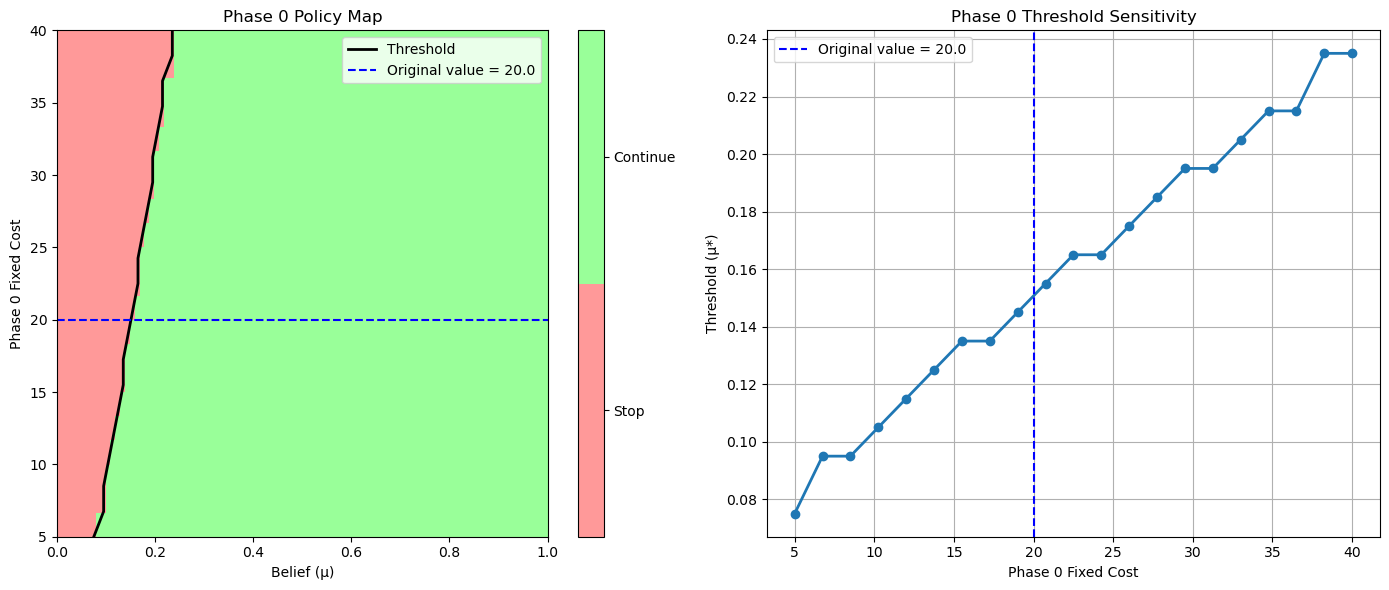

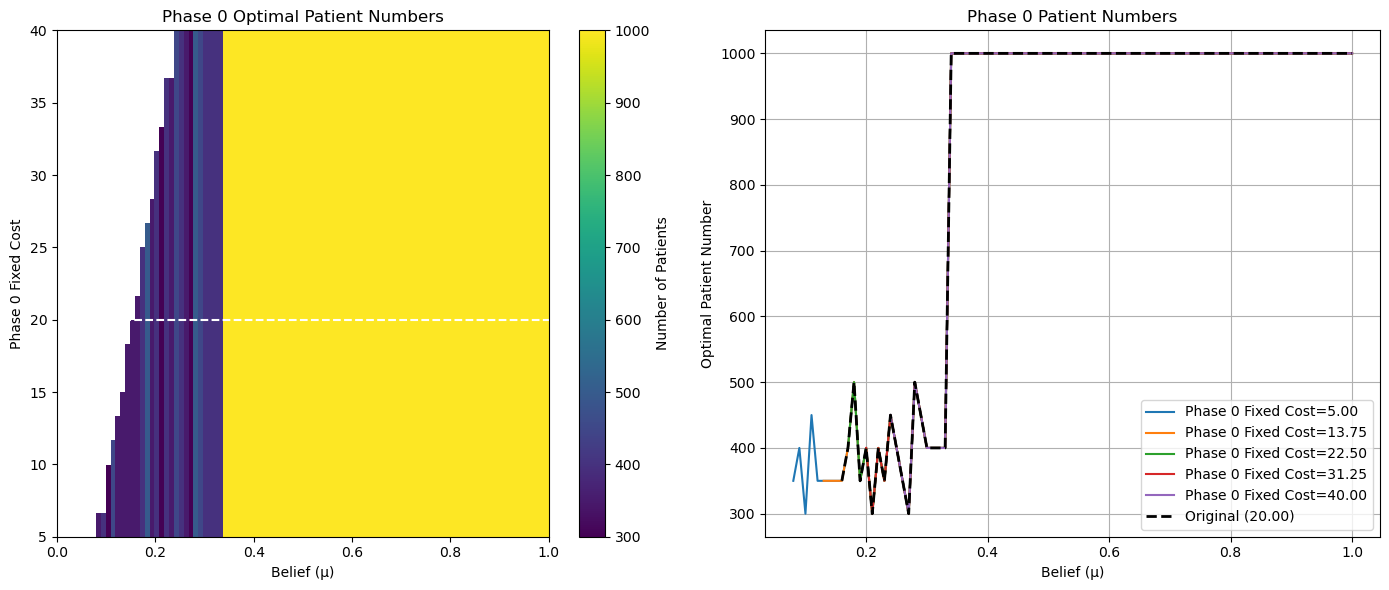


Analyzing threshold sensitivity to variable cost...


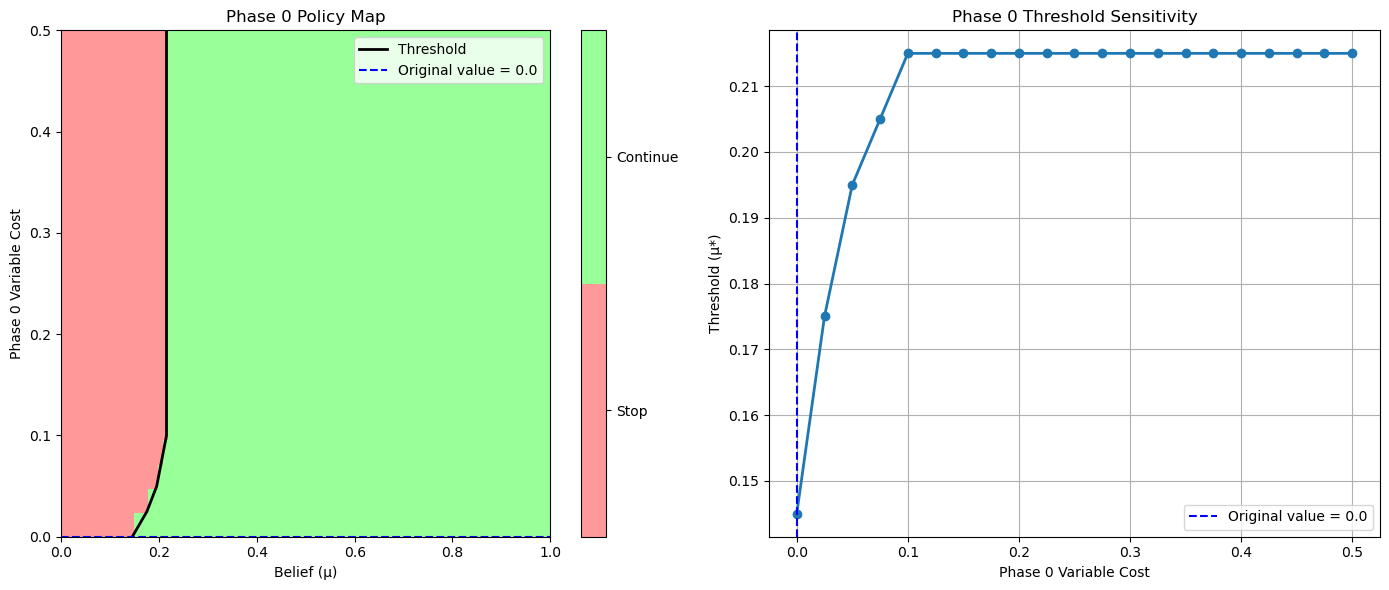

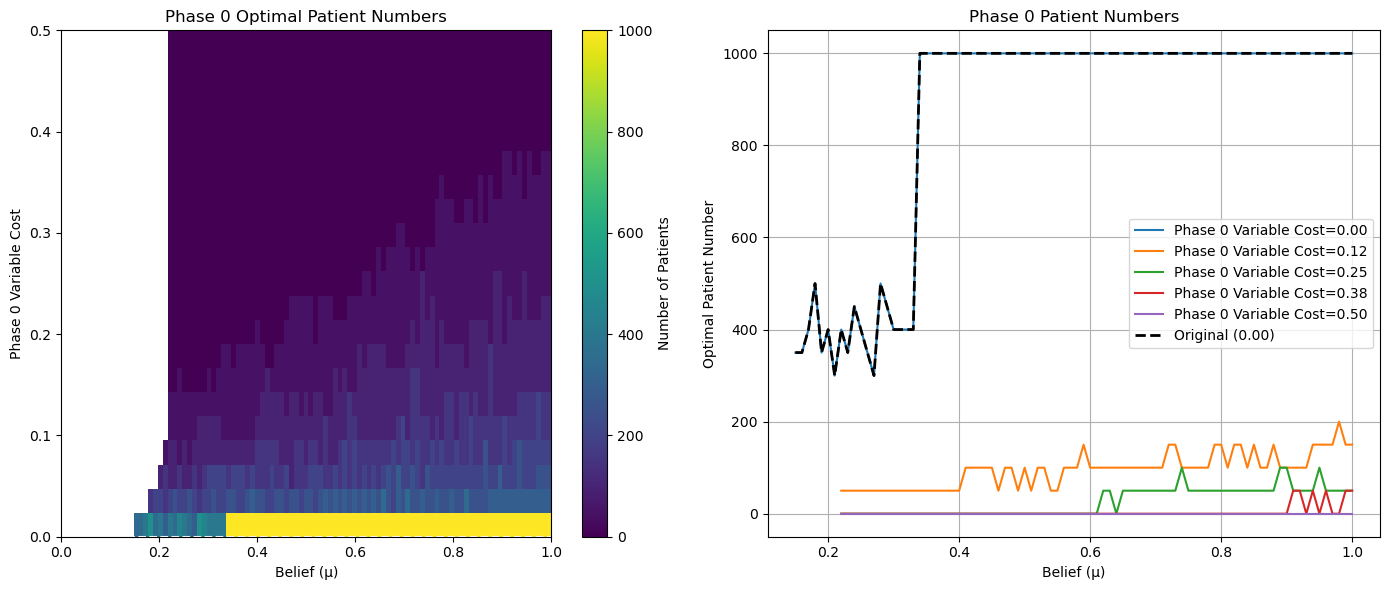


Analyzing threshold sensitivity to discount factor...


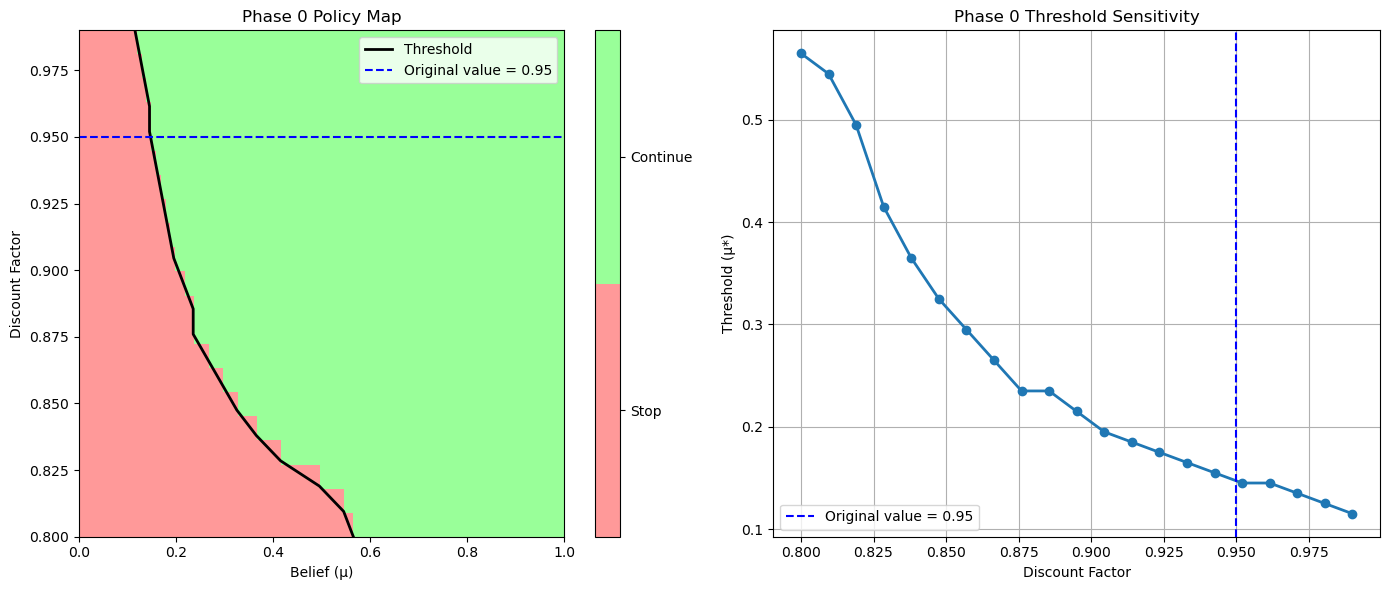


Analyzing threshold sensitivity to effective/ineffective probabilities...


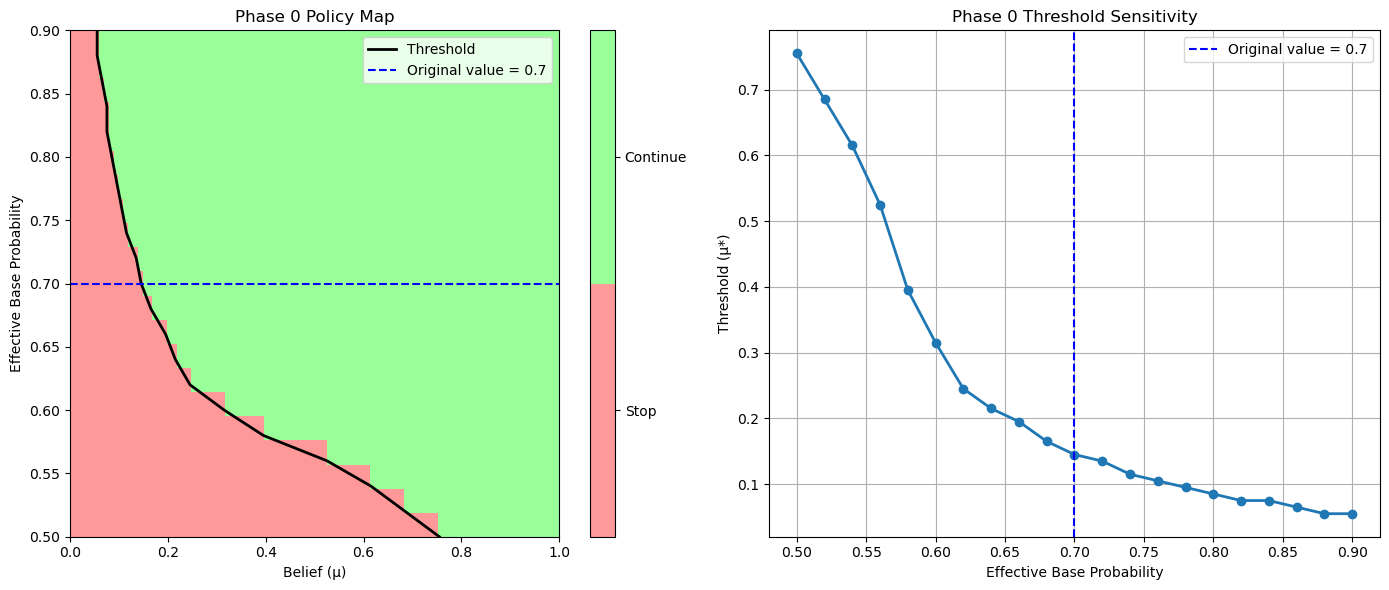


Comparing sensitivity across multiple parameters...


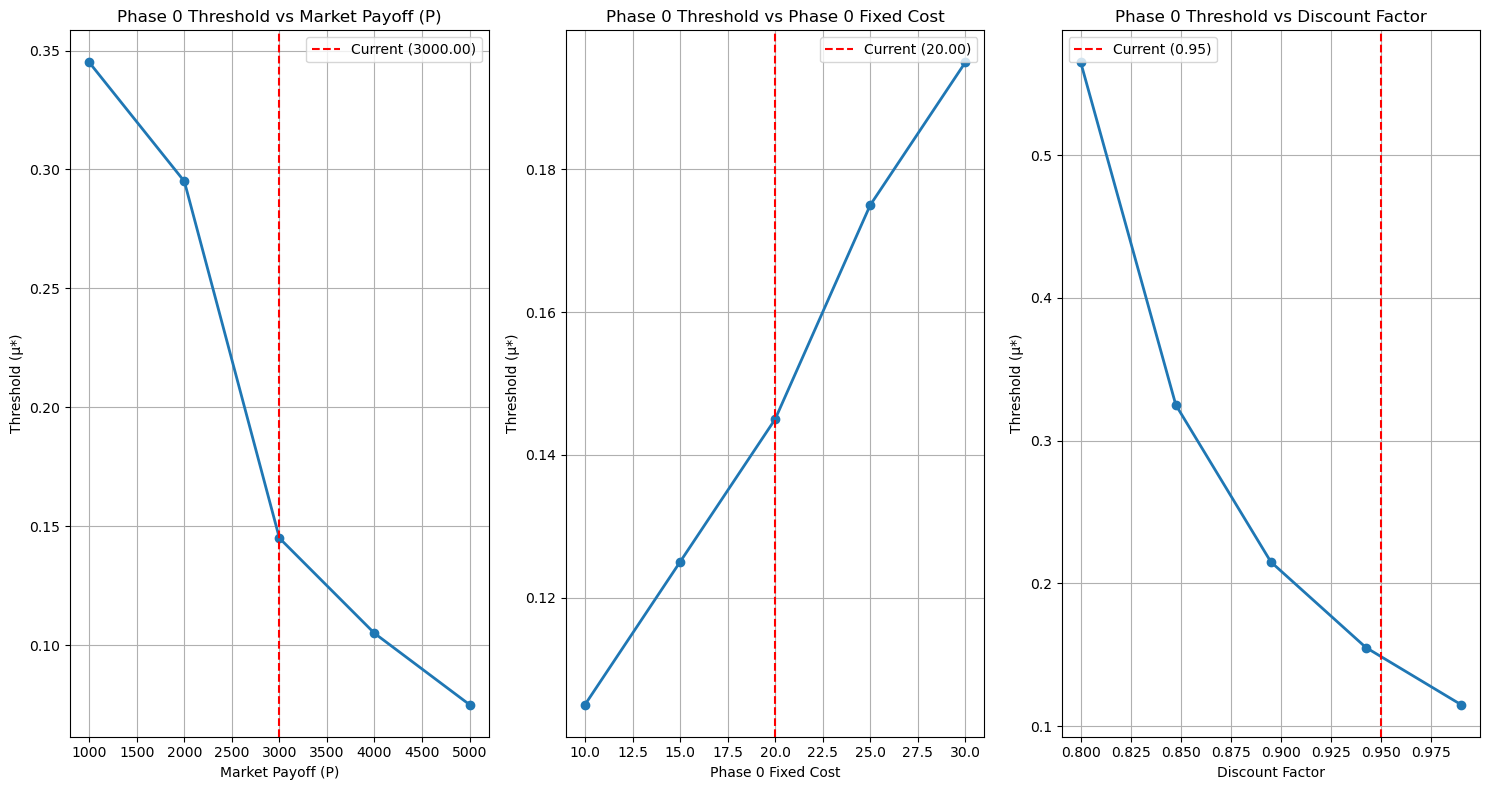


PART 3: 3D VISUALIZATIONS

Visualizing 3D value function...


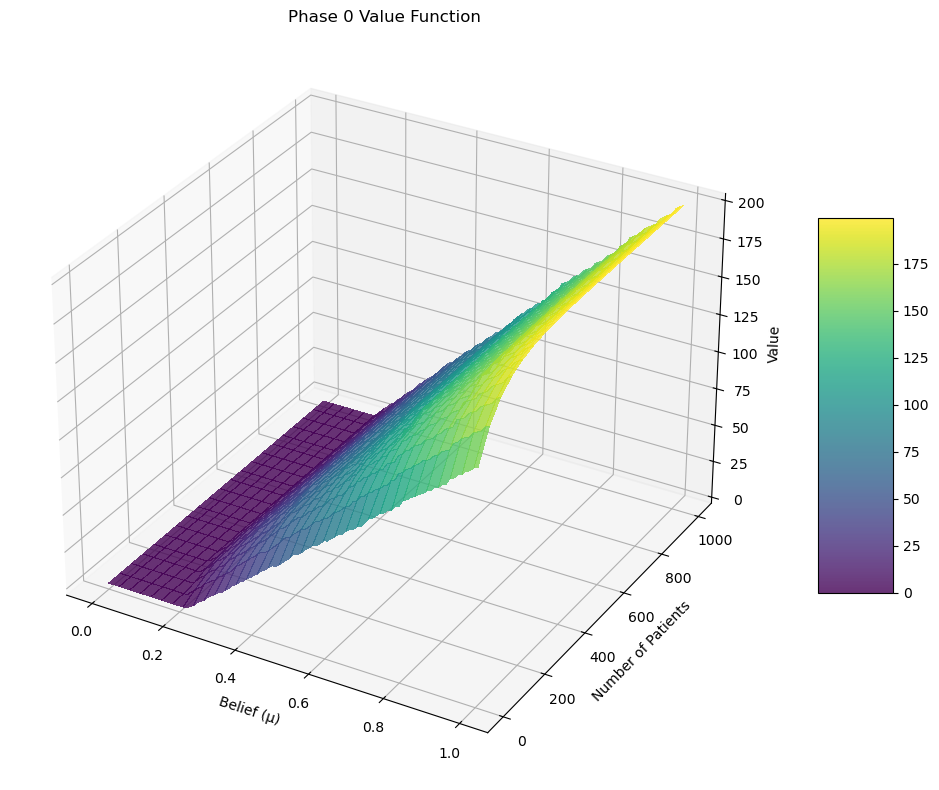


Visualizing 3D decision boundary...


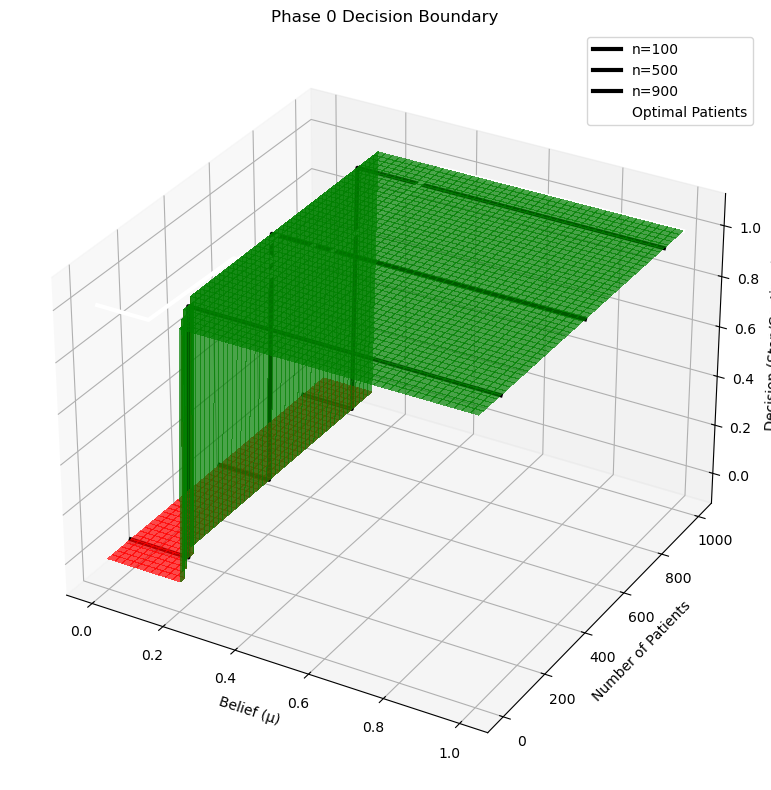


PART 4: ANALYTICAL THRESHOLD DERIVATION

Deriving analytical threshold for Phase 3...

Analytical Threshold Approximation (Phase 3):
  μ* = 0.9256
  Formula: μ* ≈ (c3 + 190.0) / (300.0 - ρ×0.56×V_RA)
  Where:
    - c3 = 550.0 (with 500 patients)
    - ρ = 0.95
    - V_RA represents regulatory approval value


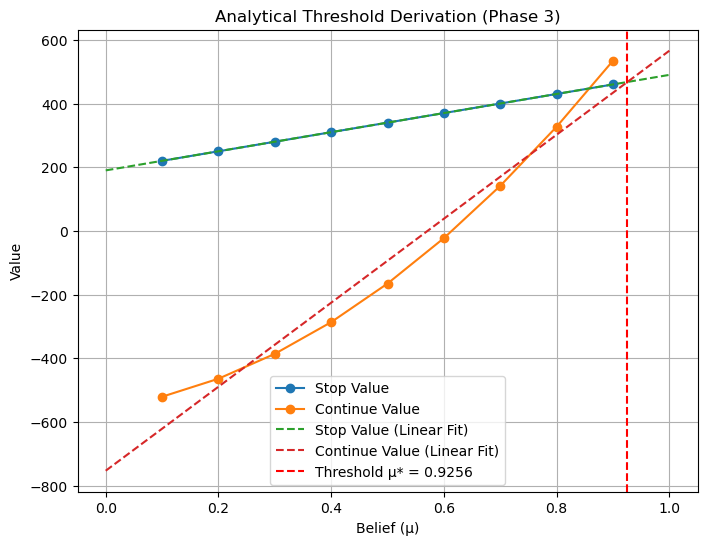


Analysis complete!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import copy

############################################################
# 1. Model Parameters
############################################################

# Phase costs - now split into fixed and variable components
c_fixed = {0: 20.0, 1: 30.0, 2: 40.0, 3: 50.0}   # Fixed costs per phase
c_var = {0: 0.0, 1: 0.1, 2: 0.2, 3: 1.0}        # Variable cost per patient

# Regulatory approval cost
c_RA = 85

# Market payoff if fully approved and marketed in-house
P = 3000.0

# Parameters for patient-dependent success probabilities
# Base probabilities
p_base_eff = {0: 0.7, 1: 0.6, 2: 0.5, 3: 0.4}   # Base prob if drug is effective
p_base_fail = {0: 0.3, 1: 0.25, 2: 0.2, 3: 0.15}  # Base prob if drug is ineffective

# Parameters for how probabilities change with patient numbers
alpha_n = {0: 0.2, 1: 0.3, 2: 0.2, 3: 0.4}      # Max improvement for effective drugs
beta_n = {0: 0.1, 1: 0.15, 2: 0.1, 3: 0.1}      # Max decrease for ineffective drugs
lambda_n = {0: 0.01, 1: 0.005, 2: 0.002, 3: 0.001}  # Rate of change for effective
delta_n = {0: 0.01, 1: 0.005, 2: 0.002, 3: 0.001}   # Rate of change for ineffective

# Probability of regulatory approval if effective/ineffective
p_approve_eff = 0.9
p_approve_fail = 0.01

# Discount factor
rho = 0.95

# Direct termination cost
C_term = 10.0

# Phase-dependent licensing payoff: L_tau(mu) = L_base[τ] + alpha_L[τ]*mu
L_base = {0: 0.0, 1: 10.0, 2: 50.0, 3: 200.0}  # Reduced from 0/20/100/300
alpha_L = {0: 40.0, 1: 80.0, 2: 150.0, 3: 300.0}  # Reduced from 100/120/200/300

# Phase-dependent outside option: O_tau(mu) = O_base[τ] + gamma_O[τ]*mu
O_base = {0: 10.0, 1: 15.0, 2: 20.0, 3: 25.0}
gamma_O = {0: 0.0, 1: 10.0, 2: 20.0, 3: 30.0}

# We'll define a special final licensing payoff if fully approved
L_final = 200.0

# Grid for mu
N_GRID = 101
MU_GRID = np.linspace(0, 1, N_GRID)

# Patient number grid - from 0 to 1000 patients
N_PATIENTS = 21
PATIENT_GRID = np.linspace(0, 1000, N_PATIENTS)

############################################################
# 2. Helper functions
############################################################

def p_effective(mu, phase, n_patients):
    """Probability of success if drug is effective, with n_patients."""
    return p_base_eff[phase] + alpha_n[phase] * (1 - np.exp(-lambda_n[phase] * n_patients))

def p_ineffective(mu, phase, n_patients):
    """Probability of false positive if drug is ineffective, with n_patients."""
    return p_base_fail[phase] - beta_n[phase] * (1 - np.exp(-delta_n[phase] * n_patients))

def p_success(mu, phase, n_patients):
    """Probability of success at phase given mu and n_patients."""
    p_eff = p_effective(mu, phase, n_patients)
    p_ineff = p_ineffective(mu, phase, n_patients)
    return mu * p_eff + (1.0 - mu) * p_ineff

def update_belief(mu, phase, n_patients):
    """Update belief after a successful outcome."""
    p_eff = p_effective(mu, phase, n_patients)
    p_ineff = p_ineffective(mu, phase, n_patients)
    if (mu * p_eff + (1.0 - mu) * p_ineff) > 1e-12:
        return (mu * p_eff) / (mu * p_eff + (1.0 - mu) * p_ineff)
    else:
        return 1.0

def phase_cost(phase, n_patients):
    """Cost function dependent on patient numbers."""
    return c_fixed[phase] + c_var[phase] * n_patients

def licensing_payoff(mu, phase):
    """Phase-dependent licensing payoff: L_tau(mu)."""
    return L_base[phase] + alpha_L[phase] * mu

def outside_option(mu, phase):
    """Phase-dependent outside option: O_tau(mu)."""
    return O_base[phase] + gamma_O[phase] * mu

def stop_value(mu, phase):
    """Stop payoff = max(Licensing, OutsideOption) - C_term."""
    return max(licensing_payoff(mu, phase),
               outside_option(mu, phase)) - C_term

def marketing_payoff(mu):
    """
    Once at final marketing stage, pick best among:
    P, L_final, or 0. 
    """
    return max(P, L_final, 0.0)

def regulatory_approval_value(mu):
    """
    If we attempt approval at mu, cost c_RA, 
    approval prob = mu*p_approve_eff + (1-mu)*p_approve_fail,
    then marketing payoff.
    """
    p_app = mu * p_approve_eff + (1.0 - mu) * p_approve_fail
    return -c_RA + rho * p_app * marketing_payoff(mu)

############################################################
# 3. Model Computation Functions
############################################################

def compute_model():
    """
    Compute the full model using backward induction.
    Returns V, policy, and opt_patients arrays.
    """
    # Arrays to store results
    V = np.zeros((5, N_GRID))  # store value
    policy = np.zeros((4, N_GRID))  # store policy for phases 0..3 (0=stop,1=cont)
    opt_patients = np.zeros((4, N_GRID))  # store optimal patient numbers
    
    # Fill V for marketing (phase 4)
    for i in range(N_GRID):
        mu_val = MU_GRID[i]
        V[4, i] = marketing_payoff(mu_val)
    
    # Phase 3
    for i in range(N_GRID):
        mu_val = MU_GRID[i]
        vs = stop_value(mu_val, 3)
        
        # Find optimal patient number for Phase 3
        best_vc = -float('inf')
        best_n = 0
        
        for n_idx, n_patients in enumerate(PATIENT_GRID):
            # continue => pay c3(n), then success => regulatory_approval_value, fail => 0
            ps = p_success(mu_val, 3, n_patients)
            vc_n = -phase_cost(3, n_patients) + rho * (ps * regulatory_approval_value(mu_val) + (1 - ps) * 0.0)
            
            if vc_n > best_vc:
                best_vc = vc_n
                best_n = n_patients
        
        V[3, i] = max(vs, best_vc)
        policy[3, i] = 1 if (best_vc > vs) else 0
        opt_patients[3, i] = best_n if (best_vc > vs) else 0
    
    # Phase 2
    for i in range(N_GRID):
        mu_val = MU_GRID[i]
        vs = stop_value(mu_val, 2)
        
        # Find optimal patient number for Phase 2
        best_vc = -float('inf')
        best_n = 0
        
        for n_idx, n_patients in enumerate(PATIENT_GRID):
            ps = p_success(mu_val, 2, n_patients)
            mu_succ = update_belief(mu_val, 2, n_patients)
            
            # Find index in mu grid for updated belief
            i_succ = int(round(mu_succ * (N_GRID - 1)))
            i_succ = max(0, min(i_succ, N_GRID - 1))  # Ensure valid index
            
            # success => V[3, i_succ], fail => 0
            EV_next = ps * V[3, i_succ] + (1 - ps) * 0.0
            vc_n = -phase_cost(2, n_patients) + rho * EV_next
            
            if vc_n > best_vc:
                best_vc = vc_n
                best_n = n_patients
        
        V[2, i] = max(vs, best_vc)
        policy[2, i] = 1 if (best_vc > vs) else 0
        opt_patients[2, i] = best_n if (best_vc > vs) else 0
    
    # Phase 1
    for i in range(N_GRID):
        mu_val = MU_GRID[i]
        vs = stop_value(mu_val, 1)
        
        # Find optimal patient number for Phase 1
        best_vc = -float('inf')
        best_n = 0
        
        for n_idx, n_patients in enumerate(PATIENT_GRID):
            ps = p_success(mu_val, 1, n_patients)
            mu_succ = update_belief(mu_val, 1, n_patients)
            
            # Find index in mu grid for updated belief
            i_succ = int(round(mu_succ * (N_GRID - 1)))
            i_succ = max(0, min(i_succ, N_GRID - 1))  # Ensure valid index
            
            # success => V[2, i_succ], fail => 0
            EV_next = ps * V[2, i_succ] + (1 - ps) * 0.0
            vc_n = -phase_cost(1, n_patients) + rho * EV_next
            
            if vc_n > best_vc:
                best_vc = vc_n
                best_n = n_patients
        
        V[1, i] = max(vs, best_vc)
        policy[1, i] = 1 if (best_vc > vs) else 0
        opt_patients[1, i] = best_n if (best_vc > vs) else 0
    
    # Phase 0
    for i in range(N_GRID):
        mu_val = MU_GRID[i]
        vs = stop_value(mu_val, 0)
        
        # Find optimal patient number for Phase 0
        best_vc = -float('inf')
        best_n = 0
        
        for n_idx, n_patients in enumerate(PATIENT_GRID):
            ps = p_success(mu_val, 0, n_patients)
            mu_succ = update_belief(mu_val, 0, n_patients)
            
            # Find index in mu grid for updated belief
            i_succ = int(round(mu_succ * (N_GRID - 1)))
            i_succ = max(0, min(i_succ, N_GRID - 1))  # Ensure valid index
            
            # success => V[1, i_succ], fail => 0
            EV_next = ps * V[1, i_succ] + (1 - ps) * 0.0
            vc_n = -phase_cost(0, n_patients) + rho * EV_next
            
            if vc_n > best_vc:
                best_vc = vc_n
                best_n = n_patients
        
        V[0, i] = max(vs, best_vc)
        policy[0, i] = 1 if (best_vc > vs) else 0
        opt_patients[0, i] = best_n if (best_vc > vs) else 0
    
    return V, policy, opt_patients

def find_threshold(policy_array):
    """Find the policy threshold in a policy array."""
    pol = policy_array
    if np.all(pol == 1):
        return 0.0
    if np.all(pol == 0):
        return 1.0
    for i in range(len(pol) - 1):
        if pol[i] == 0 and pol[i + 1] == 1:
            return 0.5 * (MU_GRID[i] + MU_GRID[i + 1])
    return 1.0

############################################################
# 4. Threshold Policy Analysis Functions
############################################################

def analyze_threshold_policy(param_name, param_values, phase_to_analyze=0):
    """
    Create a 2D policy map showing how the optimal policy varies with
    both belief state (μ) and another parameter.
    
    Args:
        param_name: String name of parameter to vary
        param_values: Array of parameter values to test
        phase_to_analyze: Which phase to visualize (default: 0)
    
    Returns:
        policy_map: 2D array where rows are parameter values, columns are μ values
        thresholds: Array of threshold values for each parameter value
        opt_patients_map: 2D array of optimal patient numbers
    """
    # Array to store policy and optimal patients for each parameter value and belief state
    policy_map = np.zeros((len(param_values), N_GRID))
    opt_patients_map = np.zeros((len(param_values), N_GRID))
    thresholds = np.zeros(len(param_values))
    
    # Store original parameters
    original_params = {
        'P': P,
        'c_fixed': copy.deepcopy(c_fixed),
        'c_var': copy.deepcopy(c_var),
        'p_base_eff': copy.deepcopy(p_base_eff),
        'p_base_fail': copy.deepcopy(p_base_fail),
        'L_base': copy.deepcopy(L_base),
        'alpha_L': copy.deepcopy(alpha_L),
        'O_base': copy.deepcopy(O_base),
        'gamma_O': copy.deepcopy(gamma_O),
        'p_approve_eff': p_approve_eff,
        'p_approve_fail': p_approve_fail,
        'C_term': C_term,
        'rho': rho,
        'alpha_n': copy.deepcopy(alpha_n),
        'beta_n': copy.deepcopy(beta_n),
        'lambda_n': copy.deepcopy(lambda_n),
        'delta_n': copy.deepcopy(delta_n)
    }
    
    # For each parameter value
    for i, param_val in enumerate(param_values):
        # Set the parameter
        if param_name == 'Market Payoff (P)':
            globals()['P'] = param_val
        elif param_name == 'Phase 0 Fixed Cost':
            c_fixed[0] = param_val
        elif param_name == 'Phase 1 Fixed Cost':
            c_fixed[1] = param_val
        elif param_name == 'Phase 2 Fixed Cost':
            c_fixed[2] = param_val
        elif param_name == 'Phase 3 Fixed Cost':
            c_fixed[3] = param_val
        elif param_name == 'Phase 0 Variable Cost':
            c_var[0] = param_val
        elif param_name == 'Phase 1 Variable Cost':
            c_var[1] = param_val
        elif param_name == 'Phase 2 Variable Cost':
            c_var[2] = param_val
        elif param_name == 'Phase 3 Variable Cost':
            c_var[3] = param_val
        elif param_name == 'Termination Cost':
            globals()['C_term'] = param_val
        elif param_name == 'Discount Factor':
            globals()['rho'] = param_val
        elif param_name == 'Regulatory Approval Probability':
            globals()['p_approve_eff'] = param_val
        elif param_name == 'Effective Base Probability':
            for ph in range(4):
                p_base_eff[ph] = param_val * original_params['p_base_eff'][ph] / original_params['p_base_eff'][0]
        elif param_name == 'Ineffective Base Probability':
            for ph in range(4):
                p_base_fail[ph] = param_val * original_params['p_base_fail'][ph] / original_params['p_base_fail'][0]
        elif param_name == 'Licensing Slope (α_L)':
            for ph in range(4):
                alpha_L[ph] = param_val * original_params['alpha_L'][ph] / original_params['alpha_L'][0]
        elif param_name == 'Outside Option Slope (γ)':
            for ph in range(4):
                gamma_O[ph] = param_val * original_params['gamma_O'][ph] / original_params['gamma_O'][1]
        elif param_name == 'Effective Probability Improvement (α_n)':
            for ph in range(4):
                alpha_n[ph] = param_val * original_params['alpha_n'][ph] / original_params['alpha_n'][0]
        elif param_name == 'Ineffective Probability Reduction (β_n)':
            for ph in range(4):
                beta_n[ph] = param_val * original_params['beta_n'][ph] / original_params['beta_n'][0]
                
        # Recompute model
        V, policy, opt_patients = compute_model()
        
        # Store the policy and optimal patients for the phase we're analyzing
        policy_map[i, :] = policy[phase_to_analyze, :]
        opt_patients_map[i, :] = opt_patients[phase_to_analyze, :]
        
        # Find threshold for this parameter value
        thresholds[i] = find_threshold(policy[phase_to_analyze, :])
        
        # Restore original parameters
        if param_name == 'Market Payoff (P)':
            globals()['P'] = original_params['P']
        elif param_name == 'Phase 0 Fixed Cost':
            c_fixed[0] = original_params['c_fixed'][0]
        elif param_name == 'Phase 1 Fixed Cost':
            c_fixed[1] = original_params['c_fixed'][1]
        elif param_name == 'Phase 2 Fixed Cost':
            c_fixed[2] = original_params['c_fixed'][2]
        elif param_name == 'Phase 3 Fixed Cost':
            c_fixed[3] = original_params['c_fixed'][3]
        elif param_name == 'Phase 0 Variable Cost':
            c_var[0] = original_params['c_var'][0]
        elif param_name == 'Phase 1 Variable Cost':
            c_var[1] = original_params['c_var'][1]
        elif param_name == 'Phase 2 Variable Cost':
            c_var[2] = original_params['c_var'][2]
        elif param_name == 'Phase 3 Variable Cost':
            c_var[3] = original_params['c_var'][3]
        elif param_name == 'Termination Cost':
            globals()['C_term'] = original_params['C_term']
        elif param_name == 'Discount Factor':
            globals()['rho'] = original_params['rho']
        elif param_name == 'Regulatory Approval Probability':
            globals()['p_approve_eff'] = original_params['p_approve_eff']
        elif param_name == 'Effective Base Probability':
            for ph in range(4):
                p_base_eff[ph] = original_params['p_base_eff'][ph]
        elif param_name == 'Ineffective Base Probability':
            for ph in range(4):
                p_base_fail[ph] = original_params['p_base_fail'][ph]
        elif param_name == 'Licensing Slope (α_L)':
            for ph in range(4):
                alpha_L[ph] = original_params['alpha_L'][ph]
        elif param_name == 'Outside Option Slope (γ)':
            for ph in range(4):
                gamma_O[ph] = original_params['gamma_O'][ph]
        elif param_name == 'Effective Probability Improvement (α_n)':
            for ph in range(4):
                alpha_n[ph] = original_params['alpha_n'][ph]
        elif param_name == 'Ineffective Probability Reduction (β_n)':
            for ph in range(4):
                beta_n[ph] = original_params['beta_n'][ph]
    
    return policy_map, thresholds, opt_patients_map

############################################################
# 5. Visualization Functions
############################################################

def plot_threshold_policy(param_name, param_values, policy_map, thresholds, phase=0, original_value=None):
    """
    Plot the threshold policy map and the threshold curve.
    
    Args:
        param_name: Name of the parameter that was varied
        param_values: Array of parameter values tested
        policy_map: 2D array of policy decisions
        thresholds: Array of threshold values
        phase: Which phase was analyzed
        original_value: The original value of the parameter (for reference line)
    """
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Policy map
    # Custom colormap for binary policy (0=Stop, 1=Continue)
    colors = ['#FF9999', '#99FF99']  # Red for stop, green for continue
    cmap = ListedColormap(colors)
    
    im = ax1.imshow(policy_map, cmap=cmap, origin='lower', 
                   extent=[0, 1, param_values[0], param_values[-1]],
                   aspect='auto')
    
    # Plot the threshold curve on top of the policy map
    ax1.plot(thresholds, param_values, 'k-', linewidth=2, label='Threshold')
    
    # Add a reference line for the original parameter value if provided
    if original_value is not None:
        ax1.axhline(y=original_value, color='blue', linestyle='--', 
                   label=f'Original value = {original_value}')
    
    ax1.set_xlabel('Belief (μ)')
    ax1.set_ylabel(param_name)
    ax1.set_title(f'Phase {phase} Policy Map')
    ax1.legend(loc='upper right')
    
    # Add colorbar
    cbar = fig.colorbar(im, ax=ax1, ticks=[0.25, 0.75])
    cbar.ax.set_yticklabels(['Stop', 'Continue'])
    
    # Plot 2: Threshold curve
    ax2.plot(param_values, thresholds, 'o-', linewidth=2)
    
    # Add a reference line for the original parameter value if provided
    if original_value is not None:
        ax2.axvline(x=original_value, color='blue', linestyle='--',
                   label=f'Original value = {original_value}')
    
    ax2.set_xlabel(param_name)
    ax2.set_ylabel('Threshold (μ*)')
    ax2.set_title(f'Phase {phase} Threshold Sensitivity')
    ax2.grid(True)
    
    if original_value is not None:
        ax2.legend()
    
    plt.tight_layout()
    plt.show()

def plot_optimal_patients(param_name, param_values, policy_map, opt_patients_map, phase=0, original_value=None):
    """
    Plot the optimal patient numbers as a function of belief state and a parameter.
    
    Args:
        param_name: Name of the parameter that was varied
        param_values: Array of parameter values tested
        policy_map: 2D array of policy decisions
        opt_patients_map: 2D array of optimal patient numbers
        phase: Which phase was analyzed
        original_value: The original value of the parameter (for reference line)
    """
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Optimal patient heatmap
    # Mask patient numbers where policy is to stop
    masked_patients = np.ma.array(opt_patients_map, mask=(policy_map == 0))
    
    im = ax1.imshow(masked_patients, origin='lower', 
                   extent=[0, 1, param_values[0], param_values[-1]],
                   aspect='auto', cmap='viridis')
    
    # Add a reference line for the original parameter value if provided
    if original_value is not None:
        ax1.axhline(y=original_value, color='white', linestyle='--', 
                   label=f'Original value = {original_value}')
    
    ax1.set_xlabel('Belief (μ)')
    ax1.set_ylabel(param_name)
    ax1.set_title(f'Phase {phase} Optimal Patient Numbers')
    
    # Add colorbar
    cbar = fig.colorbar(im, ax=ax1)
    cbar.set_label('Number of Patients')
    
    # Plot 2: Patient numbers along slices
    # Select a few parameter values to show patient numbers vs belief
    slice_indices = np.linspace(0, len(param_values)-1, 5, dtype=int)
    for idx in slice_indices:
        param_val = param_values[idx]
        masked_slice = np.ma.array(opt_patients_map[idx], mask=(policy_map[idx] == 0))
        ax2.plot(MU_GRID, masked_slice, '-', label=f'{param_name}={param_val:.2f}')
    
    # Add a reference line for the original parameter value if provided
    if original_value is not None:
        # Find closest index to original value
        orig_idx = np.abs(param_values - original_value).argmin()
        masked_orig = np.ma.array(opt_patients_map[orig_idx], mask=(policy_map[orig_idx] == 0))
        ax2.plot(MU_GRID, masked_orig, 'k--', linewidth=2, label=f'Original ({original_value:.2f})')
    
    ax2.set_xlabel('Belief (μ)')
    ax2.set_ylabel('Optimal Patient Number')
    ax2.set_title(f'Phase {phase} Patient Numbers')
    ax2.grid(True)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

def visualize_3d_value_function(phase=2, param_name=None, param_value=None):
    """
    Create a 3D visualization of value function across μ and patient numbers.
    
    Args:
        phase: Which phase to visualize
        param_name: Optional parameter to modify
        param_value: Value for the parameter if specified
    """
    # Store original value if changing a parameter
    original_value = None
    if param_name is not None and param_value is not None:
        if param_name == 'Market Payoff (P)':
            original_value = globals()['P']
            globals()['P'] = param_value
        elif param_name == 'Phase Fixed Cost':
            original_value = c_fixed[phase]
            c_fixed[phase] = param_value
        elif param_name == 'Phase Variable Cost':
            original_value = c_var[phase]
            c_var[phase] = param_value
    
    # Recompute model with potential parameter change
    V, policy, opt_patients = compute_model()
    
    # Create figure
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create a grid of μ and patient numbers
    mu_mesh, n_mesh = np.meshgrid(MU_GRID, PATIENT_GRID)
    v_mesh = np.zeros_like(mu_mesh)
    
    # Calculate value function at each point
    for i in range(len(MU_GRID)):
        for j in range(len(PATIENT_GRID)):
            mu_val = MU_GRID[i]
            n_val = PATIENT_GRID[j]
            
            # Calculate stop value
            vs = stop_value(mu_val, phase)
            
            # Calculate continue value with this patient number
            ps = p_success(mu_val, phase, n_val)
            mu_succ = update_belief(mu_val, phase, n_val)
            i_succ = int(round(mu_succ * (N_GRID - 1)))
            i_succ = max(0, min(i_succ, N_GRID - 1))
            
            next_phase = phase + 1
            EV_next = ps * V[next_phase, i_succ] + (1 - ps) * 0.0
            vc = -phase_cost(phase, n_val) + rho * EV_next
            
            # Store the maximum of stop and continue values
            v_mesh[j, i] = max(vs, vc)
    
    # Plot the surface
    surf = ax.plot_surface(mu_mesh, n_mesh, v_mesh, cmap=cm.viridis,
                        linewidth=0, antialiased=False, alpha=0.8)
    ax.set_xlabel('Belief (μ)')
    ax.set_ylabel('Number of Patients')
    ax.set_zlabel('Value')
    
    title = f'Phase {phase} Value Function'
    if param_name is not None:
        title += f' with {param_name}={param_value}'
    ax.set_title(title)
    
    # Add a color bar
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    
    # Restore original parameter if changed
    if original_value is not None:
        if param_name == 'Market Payoff (P)':
            globals()['P'] = original_value
        elif param_name == 'Phase Fixed Cost':
            c_fixed[phase] = original_value
        elif param_name == 'Phase Variable Cost':
            c_var[phase] = original_value
    
    plt.tight_layout()
    plt.show()

def visualize_3d_decision_boundary(phase=0, highlight_patients=None):
    """
    Visualize the decision boundary in 3D space (belief, patient numbers, decision).
    
    Args:
        phase: Which phase to visualize (default: 0)
        highlight_patients: List of patient numbers to highlight on the surface
    """
    # Compute model
    V, policy, opt_patients = compute_model()
    
    # Create figure
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create a grid of μ and patient numbers
    mu_grid = np.linspace(0, 1, 50)
    n_grid = np.linspace(0, 1000, 50)
    mu_mesh, n_mesh = np.meshgrid(mu_grid, n_grid)
    decision_mesh = np.zeros_like(mu_mesh)
    
    # For each point, calculate whether to stop or continue
    for i in range(len(mu_grid)):
        for j in range(len(n_grid)):
            mu_val = mu_grid[i]
            n_val = n_grid[j]
            
            # Calculate stop value
            vs = stop_value(mu_val, phase)
            
            # Calculate continue value with this patient number
            ps = p_success(mu_val, phase, n_val)
            mu_succ = update_belief(mu_val, phase, n_val)
            
            # Find index in mu grid for updated belief
            i_succ = int(round(mu_succ * (N_GRID - 1)))
            i_succ = max(0, min(i_succ, N_GRID - 1))
            
            # Value of continuing
            next_phase = phase + 1
            EV_next = ps * V[next_phase, i_succ] + (1 - ps) * 0.0
            vc = -phase_cost(phase, n_val) + rho * EV_next
            
            # Decision: 1 for continue, 0 for stop
            decision_mesh[j, i] = 1 if vc > vs else 0
    
    # Plot the decision surface
    surf = ax.plot_surface(mu_mesh, n_mesh, decision_mesh, cmap=ListedColormap(['red', 'green']),
                         linewidth=0, antialiased=False, alpha=0.7)
    
    # Highlight the optimal patient numbers if requested
    if highlight_patients is not None:
        for n_pat in highlight_patients:
            # Find closest index to this patient number
            n_idx = np.abs(n_grid - n_pat).argmin()
            # Extract the slice at this patient number
            mu_slice = mu_grid
            decision_slice = decision_mesh[n_idx, :]
            # Plot as a line on the surface
            ax.plot(mu_slice, np.ones_like(mu_slice) * n_pat, decision_slice, 'k-', linewidth=3,
                   label=f'n={n_pat}')
    
    # Also highlight the optimal patient numbers from the model
    masked_patients = np.ma.array(opt_patients[phase], mask=(policy[phase] == 0))
    ax.plot(MU_GRID, masked_patients, np.ones_like(MU_GRID), 'w-', linewidth=3,
           label='Optimal Patients')
    
    ax.set_xlabel('Belief (μ)')
    ax.set_ylabel('Number of Patients')
    ax.set_zlabel('Decision (Stop/Continue)')
    ax.set_title(f'Phase {phase} Decision Boundary')
    ax.set_zlim(-0.1, 1.1)
    
    # Add a legend
    ax.legend()
    
    plt.tight_layout()
    plt.show()

def visualize_multiparameter_thresholds(params_to_analyze=None, phase=0):
    """
    Visualize how thresholds vary with multiple parameters.
    
    Args:
        params_to_analyze: Dictionary of {param_name: values_list}
        phase: Which phase to analyze
    """
    if params_to_analyze is None:
        # Default parameters to analyze
        params_to_analyze = {
            'Market Payoff (P)': np.linspace(1000, 5000, 5),
            'Phase 0 Fixed Cost': np.linspace(10, 30, 5),
            'Discount Factor': np.linspace(0.8, 0.99, 5)
        }
    
    # Create figure
    fig = plt.figure(figsize=(15, 8))
    
    # For each parameter, compute and plot thresholds
    for i, (param_name, param_values) in enumerate(params_to_analyze.items()):
        # Get original value to mark on plot
        original_value = None
        if param_name == 'Market Payoff (P)':
            original_value = P
        elif param_name == 'Phase 0 Fixed Cost':
            original_value = c_fixed[0]
        elif param_name == 'Discount Factor':
            original_value = rho
        
        # Compute policy and thresholds
        policy_map, thresholds, _ = analyze_threshold_policy(param_name, param_values, phase_to_analyze=phase)
        
        # Add subplot
        ax = fig.add_subplot(1, len(params_to_analyze), i+1)
        ax.plot(param_values, thresholds, 'o-', linewidth=2)
        
        # Add reference line for original value
        if original_value is not None:
            ax.axvline(x=original_value, color='red', linestyle='--',
                      label=f'Current ({original_value:.2f})')
        
        ax.set_xlabel(param_name)
        ax.set_ylabel('Threshold (μ*)')
        ax.set_title(f'Phase {phase} Threshold vs {param_name}')
        ax.grid(True)
        
        if original_value is not None:
            ax.legend()
    
    plt.tight_layout()
    plt.show()

def derive_analytical_threshold(phase=3):
    """
    Derive an analytical approximation for the threshold in the specified phase.
    For simplicity, focuses on Phase 3 (simplest case).
    """
    if phase != 3:
        print("Analytical threshold derivation is currently only implemented for Phase 3")
        return None
    
    # For Phase 3, at the threshold:
    # max(L3(μ*), O3(μ*)) - C_term = -c3 + ρ[p3(μ*) × V_RA(μ*)]
    
    # Let's approximate by using:
    # 1. Average patient numbers
    # 2. Linear approximation of regulatory approval value
    
    # Assuming a grid of belief values
    mu_vals = np.linspace(0.1, 0.9, 9)
    
    # For each belief, compute stop value
    stop_vals = np.array([stop_value(mu, 3) for mu in mu_vals])
    
    # For each belief, compute continue value with average patient numbers
    avg_patients = PATIENT_GRID.mean()
    p_success_vals = np.array([p_success(mu, 3, avg_patients) for mu in mu_vals])
    ra_values = np.array([regulatory_approval_value(mu) for mu in mu_vals])
    
    continue_vals = -phase_cost(3, avg_patients) + rho * p_success_vals * ra_values
    
    # Fit linear functions to both
    stop_fit = np.polyfit(mu_vals, stop_vals, 1)
    cont_fit = np.polyfit(mu_vals, continue_vals, 1)
    
    # The threshold is where these lines intersect
    # stop_fit[0] * μ* + stop_fit[1] = cont_fit[0] * μ* + cont_fit[1]
    mu_star = (cont_fit[1] - stop_fit[1]) / (stop_fit[0] - cont_fit[0])
    
    # Compute the components of the analytical formula
    avg_p_eff = p_effective(0.5, 3, avg_patients)
    avg_p_ineff = p_ineffective(0.5, 3, avg_patients)
    
    # Create a simple formula based on our linear approximations
    formula = f"μ* ≈ (c3 + {stop_fit[1]:.1f}) / ({stop_fit[0]:.1f} - ρ×{avg_p_eff:.2f}×V_RA)"
    
    print(f"\nAnalytical Threshold Approximation (Phase 3):")
    print(f"  μ* = {mu_star:.4f}")
    print(f"  Formula: {formula}")
    print(f"  Where:")
    print(f"    - c3 = {phase_cost(3, avg_patients):.1f} (with {avg_patients:.0f} patients)")
    print(f"    - ρ = {rho}")
    print(f"    - V_RA represents regulatory approval value")
    
    # Plot the linear approximations
    plt.figure(figsize=(8, 6))
    plt.plot(mu_vals, stop_vals, 'o-', label='Stop Value')
    plt.plot(mu_vals, continue_vals, 'o-', label='Continue Value')
    
    # Plot the fitted lines
    x = np.linspace(0, 1, 100)
    plt.plot(x, stop_fit[0] * x + stop_fit[1], '--', label='Stop Value (Linear Fit)')
    plt.plot(x, cont_fit[0] * x + cont_fit[1], '--', label='Continue Value (Linear Fit)')
    
    # Mark the threshold
    plt.axvline(x=mu_star, color='red', linestyle='--', label=f'Threshold μ* = {mu_star:.4f}')
    
    plt.xlabel('Belief (μ)')
    plt.ylabel('Value')
    plt.title('Analytical Threshold Derivation (Phase 3)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return mu_star, formula

def simulate_development_path(initial_belief, num_simulations=1000):
    """
    Simulate the drug development process starting with an initial belief.
    Returns statistics about successful paths.
    """
    # Compute the model
    V, policy, opt_patients = compute_model()
    
    completed_phases = np.zeros(num_simulations, dtype=int)
    total_patients = np.zeros(num_simulations, dtype=float)
    total_costs = np.zeros(num_simulations, dtype=float)
    final_beliefs = np.zeros(num_simulations, dtype=float)
    
    for sim in range(num_simulations):
        mu = initial_belief
        phase = 0
        patients_used = 0
        cost_incurred = 0
        
        while phase < 4:
            # Find the current policy and patient numbers
            mu_idx = int(round(mu * (N_GRID - 1)))
            mu_idx = max(0, min(mu_idx, N_GRID - 1))
            
            if policy[phase, mu_idx] == 0:  # Stop
                break
            
            # Get optimal patient number
            n_patients = opt_patients[phase, mu_idx]
            patients_used += n_patients
            
            # Incur cost
            phase_cost_val = phase_cost(phase, n_patients)
            cost_incurred += phase_cost_val
            
            # Determine if trial is successful (simulate true state of the drug)
            is_effective = np.random.random() < mu  # True with probability mu
            if is_effective:
                p_success_val = p_effective(mu, phase, n_patients)
            else:
                p_success_val = p_ineffective(mu, phase, n_patients)
            
            trial_success = np.random.random() < p_success_val
            if not trial_success:
                break  # Failed trial
            
            # Update belief and move to next phase
            mu = update_belief(mu, phase, n_patients)
            phase += 1
            
            # If we've reached regulatory approval, add that cost too
            if phase == 4:
                # Regulatory approval phase
                approval_success = np.random.random() < (mu * p_approve_eff + (1 - mu) * p_approve_fail)
                cost_incurred += c_RA
                if not approval_success:
                    break
        
        # Record results
        completed_phases[sim] = phase
        total_patients[sim] = patients_used
        total_costs[sim] = cost_incurred
        final_beliefs[sim] = mu
    
    # Compute statistics
    success_rate = np.mean(completed_phases == 4)
    avg_patients = np.mean(total_patients)
    avg_cost = np.mean(total_costs)
    phases_reached = {i: np.mean(completed_phases >= i) for i in range(1, 5)}
    
    return {
        'success_rate': success_rate,
        'avg_patients': avg_patients,
        'avg_cost': avg_cost,
        'phases_reached': phases_reached,
        'completed_phases': completed_phases,
        'total_patients': total_patients,
        'total_costs': total_costs,
        'final_beliefs': final_beliefs
    }

############################################################
# 6. Main Execution
############################################################
if __name__ == "__main__":
    # Initialize model
    print("Computing base model...")
    V, policy, opt_patients = compute_model()
    
    print("\n" + "="*50)
    print("PART 1: BASIC MODEL VISUALIZATION")
    print("="*50)
    
    # Create a figure with two rows of plots
    fig = plt.figure(figsize=(15, 10))
    
    # Find thresholds
    thresholds = [find_threshold(policy[ph, :]) for ph in range(4)]
    
    # First row: Stop/Continue policy as a function of μ
    for ph in range(4):
        ax = fig.add_subplot(2, 4, ph + 1)
        pol = policy[ph, :]
        ax.plot(MU_GRID, pol, drawstyle='steps-post', label=f'Policy(phase={ph})')
        th = thresholds[ph]
        ax.axvline(x=th, color='red', linestyle='--', label=f'Threshold ~ {th:.2f}')
        ax.set_ylim(-0.1, 1.1)
        ax.set_xlabel(r"$\mu$")
        ax.set_ylabel("Policy (0=Stop, 1=Continue)")
        ax.set_title(f"Phase {ph} Decision")
        ax.legend()
    
    # Second row: Optimal patient numbers as a function of μ
    for ph in range(4):
        ax = fig.add_subplot(2, 4, ph + 5)
        # Only show patient numbers where policy is to continue
        masked_patients = np.ma.array(opt_patients[ph, :], mask=(policy[ph, :] == 0))
        
        ax.plot(MU_GRID, masked_patients, '-', label=f'Phase {ph}')
        ax.set_xlabel(r"$\mu$")
        ax.set_ylabel("Optimal Patient Number")
        ax.set_title(f"Phase {ph} Optimal Patients")
        ax.grid(True)
        
        # Add threshold line
        th = thresholds[ph]
        ax.axvline(x=th, color='red', linestyle='--')
        ax.set_ylim(0, PATIENT_GRID.max() * 1.1)  # Ensure proper y-axis limits
    
    plt.suptitle("Drug Development Policy with Patient Number Optimization", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the suptitle
    plt.show()
    
    # Print thresholds
    print("\nOptimal Belief Thresholds:")
    for ph in range(4):
        print(f"  Phase {ph}: μ* = {thresholds[ph]:.4f}")
    
    # Simulation results
    initial_belief = 0.6  # Starting belief about drug efficacy
    print(f"\nSimulating drug development paths starting with belief μ = {initial_belief}...")
    results = simulate_development_path(initial_belief)
    
    print(f"Overall success rate: {results['success_rate']:.2%}")
    print(f"Average patients enrolled: {results['avg_patients']:.1f}")
    print(f"Average development cost: ${results['avg_cost']:.1f}M")
    print("\nPhase progression rates:")
    for phase, rate in results['phases_reached'].items():
        print(f"  Reached Phase {phase}: {rate:.2%}")
    
    # Plot distribution of patients used
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(results['total_patients'], bins=20, alpha=0.7)
    plt.xlabel('Total Patients Enrolled')
    plt.ylabel('Frequency')
    plt.title('Distribution of Patient Numbers')
    
    plt.subplot(1, 2, 2)
    plt.hist(results['total_costs'], bins=20, alpha=0.7)
    plt.xlabel('Total Development Cost')
    plt.ylabel('Frequency')
    plt.title('Distribution of Development Costs')
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*50)
    print("PART 2: PARAMETER SENSITIVITY ANALYSIS")
    print("="*50)
    
    # Key parameters to analyze for policy thresholds
    print("\nAnalyzing threshold sensitivity to market payoff (P)...")
    param_name = 'Market Payoff (P)'
    param_values = np.linspace(1000, 5000, 21)
    original_value = P
    
    policy_map, thresholds, opt_patients_map = analyze_threshold_policy(param_name, param_values, phase_to_analyze=0)
    plot_threshold_policy(param_name, param_values, policy_map, thresholds, phase=0, original_value=original_value)
    plot_optimal_patients(param_name, param_values, policy_map, opt_patients_map, phase=0, original_value=original_value)
    
    print("\nAnalyzing threshold sensitivity to Phase 0 fixed cost...")
    param_name = 'Phase 0 Fixed Cost'
    param_values = np.linspace(5, 40, 21)
    original_value = c_fixed[0]
    
    policy_map, thresholds, opt_patients_map = analyze_threshold_policy(param_name, param_values, phase_to_analyze=0)
    plot_threshold_policy(param_name, param_values, policy_map, thresholds, phase=0, original_value=original_value)
    plot_optimal_patients(param_name, param_values, policy_map, opt_patients_map, phase=0, original_value=original_value)
    
    print("\nAnalyzing threshold sensitivity to variable cost...")
    param_name = 'Phase 0 Variable Cost'
    param_values = np.linspace(0, 0.5, 21)
    original_value = c_var[0]
    
    policy_map, thresholds, opt_patients_map = analyze_threshold_policy(param_name, param_values, phase_to_analyze=0)
    plot_threshold_policy(param_name, param_values, policy_map, thresholds, phase=0, original_value=original_value)
    plot_optimal_patients(param_name, param_values, policy_map, opt_patients_map, phase=0, original_value=original_value)
    
    print("\nAnalyzing threshold sensitivity to discount factor...")
    param_name = 'Discount Factor'
    param_values = np.linspace(0.8, 0.99, 21)
    original_value = rho
    
    policy_map, thresholds, opt_patients_map = analyze_threshold_policy(param_name, param_values, phase_to_analyze=0)
    plot_threshold_policy(param_name, param_values, policy_map, thresholds, phase=0, original_value=original_value)
    
    print("\nAnalyzing threshold sensitivity to effective/ineffective probabilities...")
    param_name = 'Effective Base Probability'
    param_values = np.linspace(0.5, 0.9, 21)
    original_value = p_base_eff[0]
    
    policy_map, thresholds, opt_patients_map = analyze_threshold_policy(param_name, param_values, phase_to_analyze=0)
    plot_threshold_policy(param_name, param_values, policy_map, thresholds, phase=0, original_value=original_value)
    
    # Create multi-parameter comparison
    print("\nComparing sensitivity across multiple parameters...")
    visualize_multiparameter_thresholds(phase=0)
    
    print("\n" + "="*50)
    print("PART 3: 3D VISUALIZATIONS")
    print("="*50)
    
    print("\nVisualizing 3D value function...")
    visualize_3d_value_function(phase=0)
    
    print("\nVisualizing 3D decision boundary...")
    visualize_3d_decision_boundary(phase=0, highlight_patients=[100, 500, 900])
    
    print("\n" + "="*50)
    print("PART 4: ANALYTICAL THRESHOLD DERIVATION")
    print("="*50)
    
    # Derive analytical threshold for Phase 3
    print("\nDeriving analytical threshold for Phase 3...")
    mu_star, formula = derive_analytical_threshold(phase=3)
    
    print("\nAnalysis complete!")